## Increasing the rate

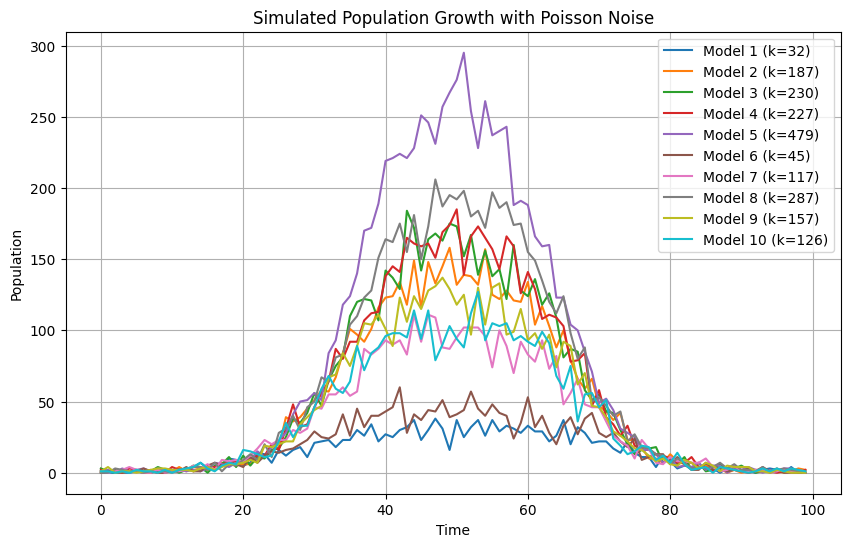

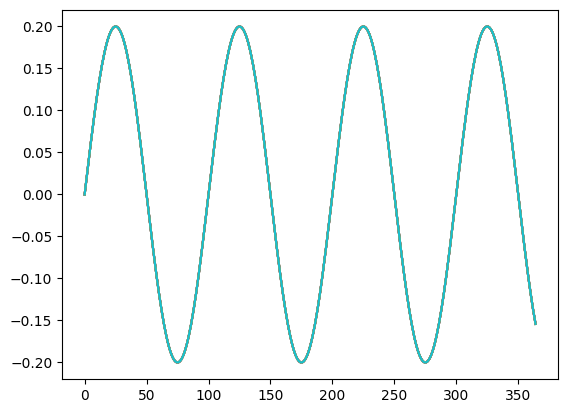

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd


num_models = 10
rng = np.random.default_rng()
d=100
t=np.linspace(0,2*d,2*d+1)
#r1_s = np.array([rng.uniform(0,0.5) for _ in range(num_models)])
def r_t(t,i):
    return 0.2 * np.sin((2 * np.pi) * t/d)

def growthEQ(t, y,i):
    r = r_t(t,i)
    #r = 0.1
    return r*y*(1 - (y/carrying_cap))

time = 100
states = np.ones(num_models)
k_vals = [rng.integers(10,500) for _ in range(num_models)]
#k_vals = [100]

data = np.empty([num_models, time])


for i in range(num_models):
    if len(states) != num_models or len(k_vals) != num_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=lambda t, y: growthEQ(t,y,i), 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i] = rng.poisson(sol.y[0])
    #data[i] = (sol.y[0])


# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

for i in range(num_models):
    plt.plot([r_t(t,i) for t in range(365)])


In [4]:
'''Entry point for the particle filtering code '''

import sys
sys.path.append('../')
import numpy as np
from copy import deepcopy

from Implementations.algorithms.TimeDependentBeta import TimeDependentAlgo
from Implementations.algorithms.Experiment import ExperimentAlgo
from Implementations.resamplers.resamplers import PoissonResampleExperiment, LogNBinomResampleExperiment,NBinomResampleExperiment
from Implementations.solvers.DeterministicSolvers import LSODACalvettiSolver,LSODASolverExperimentLogistic,LSODASolverSEIARHD, EulerSolverExperiment
from Implementations.perturbers.perturbers import LogMultivariatePerturbations, ExperimentPerturb,LinExperimentPerturb
from utilities.Utils import Context,ESTIMATION
from utilities.sankey import visualize_particles
from functools import partial


'''Algorithm object encapsulating all the requirements

The integrator is an object which runs the t->t+1 propagation of the particles, primarily using the LSODA 
integrator built in to scipy.integrate(solve_ivp)

The perturb object performs multivariate perturbations on the state variables and the estimated variables

The resampler computes the weights and resamples based on a known algorithm(multinomial,systematic,residual)



'''
algo = ExperimentAlgo(integrator = LSODASolverExperimentLogistic(),
                        perturb = ExperimentPerturb(hyper_params={'sigma':0.1,'h':0.01}),
                        resampler = NBinomResampleExperiment(),
                        ctx=Context(population=20,
                                    state_size = num_models,
                                    weights=np.zeros(100),
                                    seed_loc=np.arange(num_models),
                                    seed_size=5,
                                    forward_estimation=1,
                                    rng=rng,
                                    particle_count=1000,
                                    run_sankey=False)
                                    )

algo.initialize(params={
"r": ESTIMATION.VARIABLE,
"k": 3,
"mu": 0.,
"R": 50
}
,priors={
"r": partial(algo.ctx.rng.uniform, -0.1, 0.1),
"k": partial(algo.ctx.rng.multivariate_normal, [100,100,100,100,100],25*np.eye(5)),
"mu": partial(algo.ctx.rng.uniform, 0.02, 0.07),
"R":partial(algo.ctx.rng.uniform, 10, 50)
})

'''Runs the PF over the specified data set for the specified length of time'''
for particle in algo.particles:
    particle.param["k"] = np.array(deepcopy(k_vals))
    # particle.param["r"] = np.zeros(num_models)

#algo.print_particles()

algo.run(f'../datasets/resample_experiment_time_series.csv',300)




Iteration: 0
r: -0.00030100999794204647
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 1
r: 0.010732617731398034
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 2
r: -0.10954357569221444
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 3
r: -0.20210173754499725
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 4
r: -0.10383051276250468
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 5
r: 0.03561106518375854
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 6
r: -0.03156256556403185
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 7
r: -0.03974525934874526
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 8
r: 0.023935246245300846
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0
Iteration: 9
r: 0.02210829008506795
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: 0.0

IndexError: index 100 is out of bounds for axis 0 with size 100

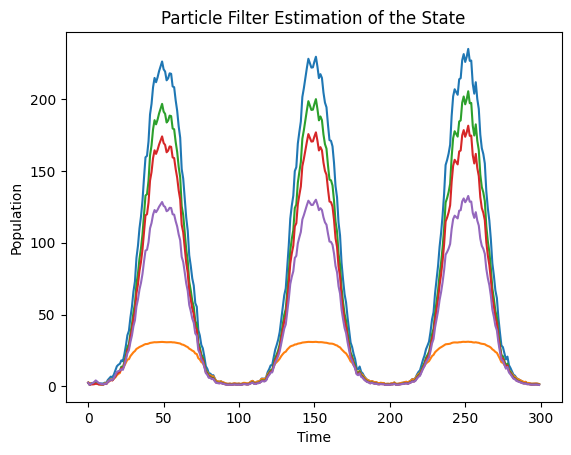

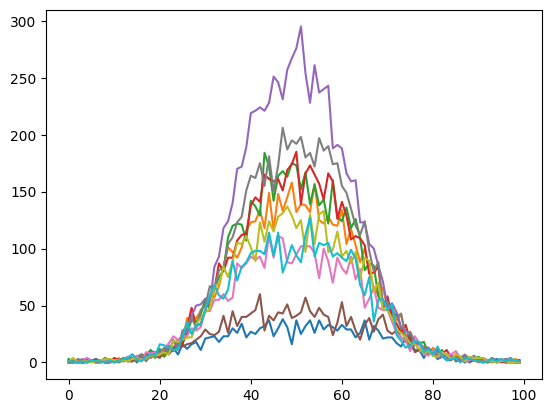

0.2029797621583808


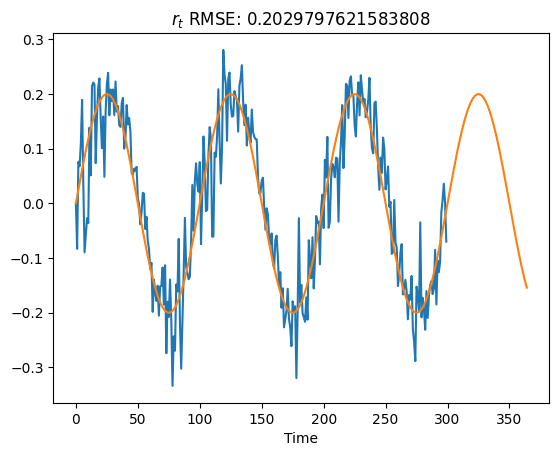

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

pf_state = pd.read_csv('../datasets/state_quantiles.csv').to_numpy()
pf_state = np.delete(pf_state,0,1)
pf_r = pd.read_csv('../datasets/r_quantiles.csv').to_numpy()
pf_r = np.delete(pf_r,0,1)
pf_mu = pd.read_csv('../datasets/mu_quantiles.csv').to_numpy()
pf_mu = np.delete(pf_mu,0,1)


real_data = pd.read_csv('../datasets/resample_experiment_time_series.csv').to_numpy()
#real_data = np.delete(real_data,0,1)


plt.title("Particle Filter Estimation of the State")
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(pf_state)
plt.show()
plt.plot(real_data)
plt.show()


plt.xlabel('Time')
plt.plot(pf_r)
#plt.plot(r_t(t))
# for i in range(num_models):
#compute RMSE

plt.plot([r_t(t,0) for t in range(365)])
rmse = np.sqrt(np.mean((np.array([r_t(t,0) for t in range(365)]) - pf_r)**2))
plt.title(f"$r_t$ RMSE: {rmse}")
print(rmse)
plt.show()


In [6]:
'''Entry point for the particle filtering code '''

import sys
sys.path.append('../')
import numpy as np
from copy import deepcopy

from Implementations.algorithms.TimeDependentBeta import TimeDependentAlgo
from Implementations.algorithms.Experiment import ExperimentAlgo
from Implementations.resamplers.resamplers import PoissonResample, LogPoissonResampleExperiment,NBinomResampleExperiment
from Implementations.solvers.DeterministicSolvers import LSODACalvettiSolver,LSODASolverExperimentLogistic,LSODASolverSEIARHD, EulerSolverExperiment
from Implementations.perturbers.perturbers import LogMultivariatePerturbations, ExperimentPerturb,LinExperimentPerturb
from utilities.Utils import Context,ESTIMATION
from utilities.sankey import visualize_particles
from functools import partial


'''Algorithm object encapsulating all the requirements

The integrator is an object which runs the t->t+1 propagation of the particles, primarily using the LSODA 
integrator built in to scipy.integrate(solve_ivp)

The perturb object performs multivariate perturbations on the state variables and the estimated variables

The resampler computes the weights and resamples based on a known algorithm(multinomial,systematic,residual)



'''
algo = ExperimentAlgo(integrator = LSODASolverExperimentLogistic(),
                        perturb = ExperimentPerturb(hyper_params={'sigma':0.1,'h':0.01}),
                        resampler = LogNBinomResampleExperiment(),
                        ctx=Context(population=20,
                                    state_size = num_models,
                                    weights=np.zeros(1000),
                                    seed_loc=np.arange(num_models),
                                    seed_size=5,
                                    forward_estimation=1,
                                    rng=rng,
                                    particle_count=1000,
                                    run_sankey=False)
                                    )

algo.initialize(params={
"r": ESTIMATION.VARIABLE,
"k": 3,
"mu": 0.,
"R": 50
}
,priors={
"r": partial(algo.ctx.rng.uniform, -0.1, 0.1),
"k": partial(algo.ctx.rng.multivariate_normal, [100,100,100,100,100],25*np.eye(5)),
"mu": partial(algo.ctx.rng.uniform, 0.02, 0.07),
"R":partial(algo.ctx.rng.uniform, 10, 50)
})

'''Runs the PF over the specified data set for the specified length of time'''
for particle in algo.particles:
    particle.param["k"] = np.array(deepcopy(k_vals))
    # particle.param["r"] = np.zeros(num_models)

#algo.print_particles()

algo.run(f'../datasets/resample_experiment_time_series.csv',300)



Iteration: 0
r: -0.0010407460563343156
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 1
r: -0.13617300400174573
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 2
r: -0.22021765282468111
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 3
r: -0.1936221620618101
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 4
r: -0.05861961816949234
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 5
r: 0.19600832930115186
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 6
r: 0.06611206968068398
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 7
r: -0.17066308300042204
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 8
r: -0.010665882026193832
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.]
mu: -0.0
Iteration: 9
r: 0.0059033837604198815
k: [ 32. 187. 230. 227. 479.  45. 117. 287. 157. 126.

IndexError: index 100 is out of bounds for axis 0 with size 100

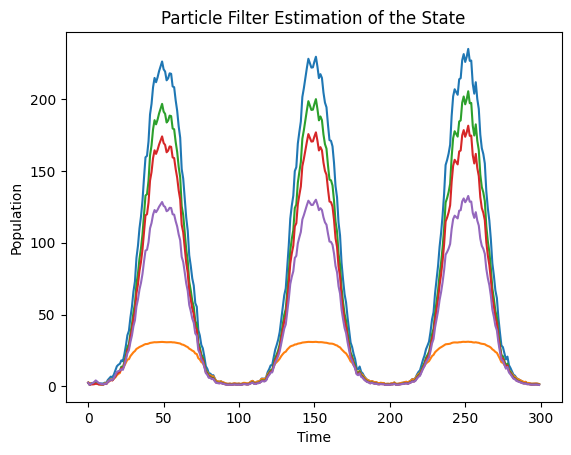

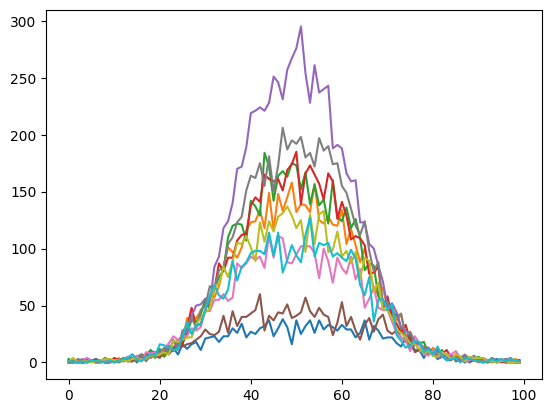

0.2029797621583808


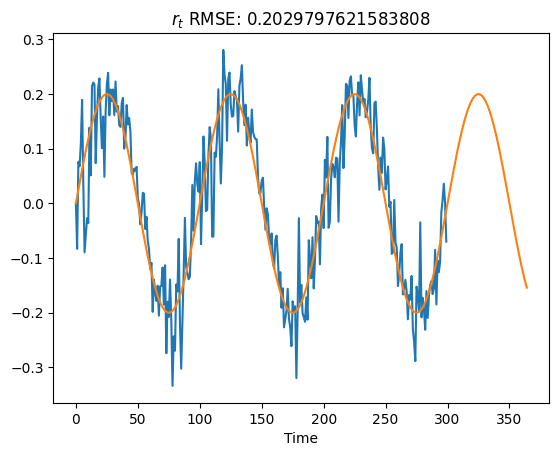

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

pf_state = pd.read_csv('../datasets/state_quantiles.csv').to_numpy()
pf_state = np.delete(pf_state,0,1)
pf_r = pd.read_csv('../datasets/r_quantiles.csv').to_numpy()
pf_r = np.delete(pf_r,0,1)
pf_mu = pd.read_csv('../datasets/mu_quantiles.csv').to_numpy()
pf_mu = np.delete(pf_mu,0,1)


real_data = pd.read_csv('../datasets/resample_experiment_time_series.csv').to_numpy()
#real_data = np.delete(real_data,0,1)


plt.title("Particle Filter Estimation of the State")
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(pf_state)
plt.show()
plt.plot(real_data)
plt.show()


plt.xlabel('Time')
plt.plot(pf_r)
#plt.plot(r_t(t))
# for i in range(num_models):
#compute RMSE

plt.plot([r_t(t,0) for t in range(365)])
rmse = np.sqrt(np.mean((np.array([r_t(t,0) for t in range(365)]) - pf_r)**2))
plt.title(f"$r_t$ RMSE: {rmse}")
print(rmse)
plt.show()
